In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [ ]:
#import libraries and data

import pandas as pd
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2015, 1, 1)
end = datetime.date.today()

# get the data for the bitcoin
btc = web.DataReader('BTC-USD', 'yahoo', start, end)['Close'][:,None]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


Epoch 1/100
1935/1935 - 4s - loss: 0.0415
Epoch 2/100
1935/1935 - 2s - loss: 7.8440e-04
Epoch 3/100
1935/1935 - 2s - loss: 7.0482e-04
Epoch 4/100
1935/1935 - 2s - loss: 6.7124e-04
Epoch 5/100
1935/1935 - 2s - loss: 6.7146e-04
Epoch 6/100
1935/1935 - 2s - loss: 6.6185e-04
Epoch 7/100
1935/1935 - 2s - loss: 6.6848e-04
Epoch 8/100
1935/1935 - 2s - loss: 6.8359e-04
Epoch 9/100
1935/1935 - 2s - loss: 6.5213e-04
Epoch 10/100
1935/1935 - 2s - loss: 6.4486e-04
Epoch 11/100
1935/1935 - 2s - loss: 6.5443e-04
Epoch 12/100
1935/1935 - 2s - loss: 6.3806e-04
Epoch 13/100
1935/1935 - 2s - loss: 6.5593e-04
Epoch 14/100
1935/1935 - 2s - loss: 6.5188e-04
Epoch 15/100
1935/1935 - 2s - loss: 6.4296e-04
Epoch 16/100
1935/1935 - 2s - loss: 6.4804e-04
Epoch 17/100
1935/1935 - 2s - loss: 6.6117e-04
Epoch 18/100
1935/1935 - 2s - loss: 6.3721e-04
Epoch 19/100
1935/1935 - 2s - loss: 6.4360e-04
Epoch 20/100
1935/1935 - 2s - loss: 6.1564e-04
Epoch 21/100
1935/1935 - 2s - loss: 6.4139e-04
Epoch 22/100
1935/1935 - 2

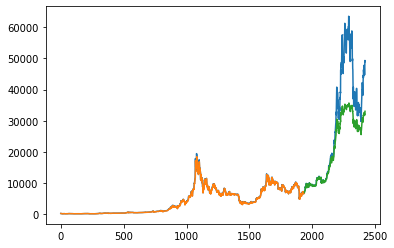

In [ ]:
''' A LSTM network for analyzing data. Any good AI engineer would understand this code.
It seems to predict the test set surprisingly well.
'''

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


# convert the data to a numpy array
dataset = btc
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 5))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.80 )
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(np.mean(np.power(trainY[0]-trainPredict[:,0],2)))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(np.mean(np.power(testY[0]-testPredict[:,0],2)))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
# Predict Next Day's prices
last_30_days = scaler.transform(btc[-30:])
next_day = model.predict(np.reshape(last_30_days, (1,30,1)))
print("Next day prediction: ", scaler.inverse_transform(next_day))


Next day prediction:  [[42782.773]]


In [ ]:
import requests

#telegram bot token
token = 'your token'

#chat id
chat_id = 'chat id'

#message to be sent
message = 'Bitcoin price for tomorrow is: ' + str(scaler.inverse_transform(next_day))

#send message
send_message = 'https://api.telegram.org/bot' + token + '/sendMessage?chat_id=' + chat_id + '&parse_mode=Markdown&text=' + message

response = requests.get(send_message)

print(response.json())

{'ok': True, 'result': {'message_id': 4, 'sender_chat': {'id': -1001245290567, 'title': 'BTC_Tomorrow', 'type': 'channel'}, 'chat': {'id': -1001245290567, 'title': 'BTC_Tomorrow', 'type': 'channel'}, 'date': 1629612721, 'text': 'Bitcoin price for tomorrow is: [42782.773]'}}
